
[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


gen	nevals	avg     	min     	max     
0  	50    	0.765306	0.653061	0.826531
1  	31    	0.780408	0.704082	0.826531
2  	32    	0.792041	0.72449 	0.826531
3  	36    	0.803265	0.765306	0.826531
4  	34    	0.803673	0.714286	0.826531
5  	29    	0.808163	0.714286	0.826531
6  	38    	0.811429	0.72449 	0.826531
7  	33    	0.819388	0.755102	0.826531
8  	28    	0.826531	0.816327	0.836735
9  	29    	0.826327	0.795918	0.836735
10 	35    	0.827143	0.816327	0.836735
11 	34    	0.826735	0.785714	0.836735
12 	29    	0.829388	0.826531	0.836735
13 	35    	0.830204	0.785714	0.836735
14 	31    	0.832653	0.785714	0.836735
15 	30    	0.832449	0.72449 	0.836735
16 	29    	0.835918	0.795918	0.836735
17 	27    	0.834898	0.795918	0.836735
18 	32    	0.835306	0.806122	0.836735
19 	25    	0.836531	0.826531	0.836735
20 	39    	0.834286	0.765306	0.836735
Best individual:  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Number of selected features:  5
Accuracy:  0.8367346938775511
              precision    recall  f1-score 

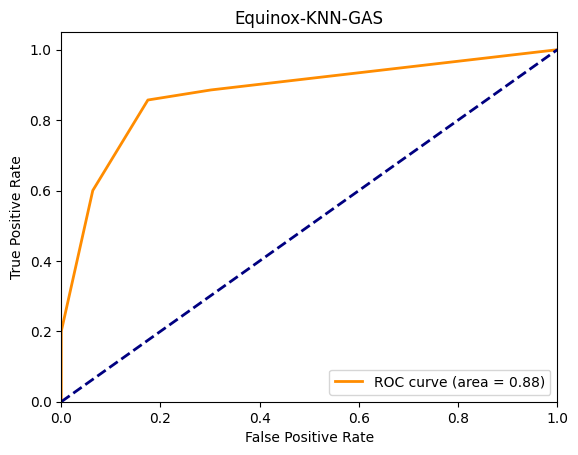

In [1]:
import sys
!{sys.executable} -m pip install deap
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer  # For handling NaNs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
import random

# Load the data
data = pd.read_csv('equinox.csv')

# Convert 'bugs' column to binary (assuming 0 means no bug, and >0 means there's a bug)
data['bugs_binary'] = data['bugs'].apply(lambda x: 1 if x > 0 else 0)

# Pre-process the data
columns_to_drop = ['classname', 'bugs', 'nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs', 'bugs_binary']
X = data.drop(columns=columns_to_drop)
y = data['bugs_binary']

# Handle NaN values
X = X.dropna(axis=1, how='all')

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply imputation on our dataset
X_imputed = pd.DataFrame(imputer.fit_transform(X))

# # the column names got removed after imputation, put them back
X_imputed.columns = X.columns

# # the index got removed after imputation, put it back
X_imputed.index = X.index

# Update X to be the imputed data
X = X_imputed

negative_features = X.columns[(X < 0).any()]
X = X.drop(columns=negative_features)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the evaluation function for the Genetic Algorithm
def evalFeatureSelection(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:
        return (0,)
    
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    return (accuracy,)


# Set up the Genetic Algorithm using DEAP

# Create the types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register the functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalFeatureSelection)

# Run the Genetic Algorithm for feature selection:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)


# Train and evaluate the classifier using the best feature subset found:
best_individual = hof[0]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Best individual: ", best_individual)
print("Number of selected features: ", len(selected_features))

# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = KNeighborsClassifier()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/Equinox/Equinox_KNN_GAS.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equinox-KNN-GAS')
plt.legend(loc="lower right")
plt.show()